In [ ]:
# Người sử dụng thay đổi ở đây
# Link file
link = 'https://storage.googleapis.com/protonx-cloud-storage/data_20200828.xlsx'
# Tên sheet muốn dùng
sheet_name = 'USDVND'
# Tên cột muốn dự đoán
col = 'Rate'

In [ ]:
!wget $link -O data.xlsx

--2021-01-08 08:47:19--  https://storage.googleapis.com/protonx-cloud-storage/data_20200828.xlsx
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.97.128, 108.177.125.128, 64.233.189.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.97.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 196205 (192K) [application/octet-stream]
Saving to: ‘data.xlsx’

data.xlsx           100%[===================>] 191.61K  --.-KB/s    in 0.001s  

2021-01-08 08:47:19 (140 MB/s) - ‘data.xlsx’ saved [196205/196205]



### Code hiển thị 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

### Load dữ liệu

In [ ]:
import pandas as pd
xls = pd.ExcelFile('data.xlsx')

### Danh sách các sheet

In [ ]:
xls.sheet_names 

['Result',
 'USDVND',
 'VNDON',
 'VND1W',
 'VND2W',
 'VND1M',
 'VND3M',
 'VND6M',
 'USDON',
 'USD1W',
 'USD2W',
 'USD1M',
 'USD3M',
 'YIELD1Y',
 'YIELD5Y',
 'YIELD10Y']

### Lựa chọn Sheet mong muốn sử dụng. Trong trường hợp này sử dụng sheet `USDVND`

In [ ]:
df = pd.read_excel(xls, sheet_name)

In [ ]:
df

,Date,Rate
0,2018-01-01,22700.0
1,2018-01-02,22708.0
2,2018-01-03,22710.0
3,2018-01-04,22710.0
4,2018-01-05,22710.0
...,...,...
766,2020-12-08,23150.0
767,2020-12-09,23150.0
768,2020-12-10,23150.0
769,2020-12-11,23150.0


### Lấy data cột Rate

In [ ]:
import numpy as np
series = np.array(df[col])

### Lấy chiều dài thời gian. Dạng [0, 1, ....]

In [ ]:
time = np.arange(len(series))

### Hiển thị dữ liệu

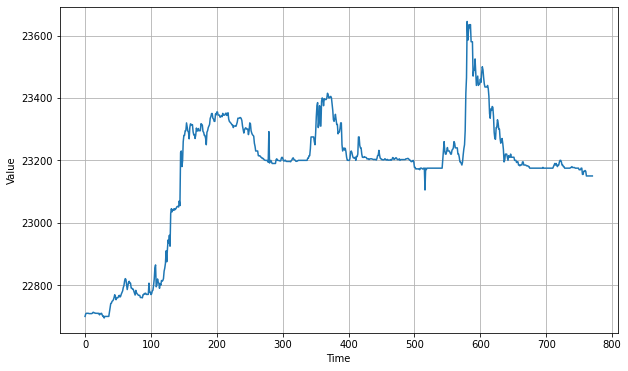

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time, series)

### Chuẩn hóa dữ liệu. Sử dụng Min-Max Scale

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
series = scaler.fit_transform(series.reshape(-1, 1))
series = series.flatten()

In [ ]:
series[:10]

array([0.00526316, 0.01368421, 0.01578947, 0.01578947, 0.01578947,
       0.01578947, 0.01473684, 0.01473684, 0.01473684, 0.01473684])

### Chia tập Train và tập Test

Tỉ lệ 80 - 20

In [ ]:
rate = 0.9
split_time = int(rate * len(series))
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [ ]:
len(x_train), len(x_valid)

(693, 78)

### Thiết kế cửa sổ để xây dựng bộ dữ liệu

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

### Hàm dự đoán

In [ ]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

### Xây dựng model

#### Model 1 : LSTM

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional

tf.random.set_seed(0)
np.random.seed(0)

train_set = windowed_dataset(x_train, window_size=60, batch_size=64, shuffle_buffer=shuffle_buffer_size)

tf.random.set_seed(0)
np.random.seed(0)

train_set = windowed_dataset(x_train, window_size=60, batch_size=64, shuffle_buffer=shuffle_buffer_size)
model = Sequential([
                    LSTM(64, return_sequences=True),
                    LSTM(64, return_sequences=True),
                    Dense(32, activation='relu'),
                    Dense(16, activation='relu'),
                    Dense(1)
])
model.compile(loss=tf.keras.losses.Huber(), optimizer='adam', metrics=['mae'])
history = model.fit(train_set, epochs=100)


Epoch 1/100
10/10 [==============================] - 4s 11ms/step - loss: 0.1364 - mae: 0.4823
Epoch 2/100
10/10 [==============================] - 0s 10ms/step - loss: 0.0298 - mae: 0.1984
Epoch 3/100
10/10 [==============================] - 0s 12ms/step - loss: 0.0182 - mae: 0.1441
Epoch 4/100
10/10 [==============================] - 0s 11ms/step - loss: 0.0119 - mae: 0.1095
Epoch 5/100
10/10 [==============================] - 0s 11ms/step - loss: 0.0093 - mae: 0.0875
Epoch 6/100
10/10 [==============================] - 0s 11ms/step - loss: 0.0079 - mae: 0.0746
Epoch 7/100
10/10 [==============================] - 0s 11ms/step - loss: 0.0067 - mae: 0.0690
Epoch 8/100
10/10 [==============================] - 0s 11ms/step - loss: 0.0061 - mae: 0.0615
Epoch 9/100
10/10 [==============================] - 0s 11ms/step - loss: 0.0053 - mae: 0.0554
Epoch 10/100
10/10 [==============================] - 0s 11ms/step - loss: 0.0049 - mae: 0.0509
Epoch 11/100
10/10 [=============================

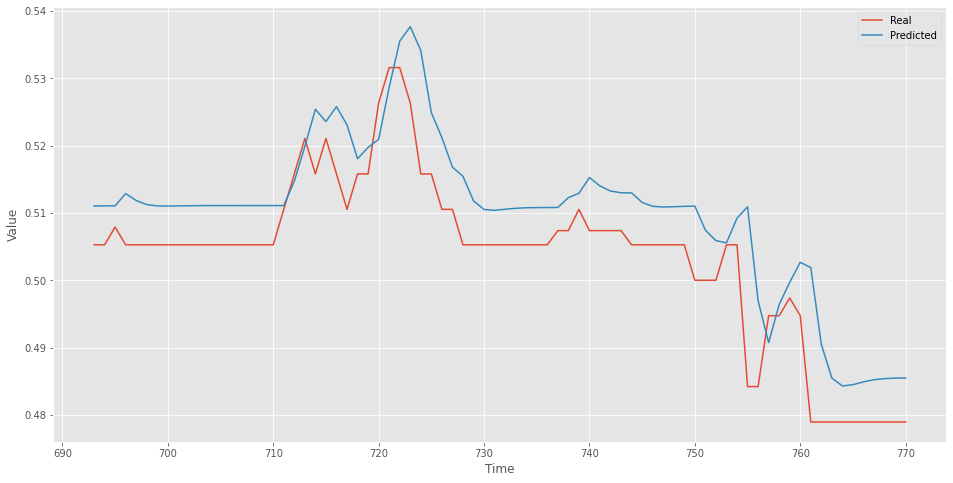

In [ ]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]
with plt.style.context('ggplot'):
    plt.figure(figsize=(16, 8))
    plot_series(time_valid, x_valid)
    plot_series(time_valid, rnn_forecast)
    labels = ['Real', 'Predicted']
    plt.legend(labels)
    plt.show()